In [2]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
#import gensim
#from gensim.models.doc2vec import Doc2Vec, TaggedDocument 

In [3]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

def twenty_newsgroup_to_csv():
    newsgroups_train = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    out.to_csv('20_newsgroup.csv')
    
twenty_newsgroup_to_csv()

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\pandas\core\arrays\datetimes.py:2199: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(


In [4]:
data = pd.read_csv('20_newsgroup.csv', index_col = 0)
# Select only 5 classes
class_mask = data["target"].isin([7,9,13,18,19])
data = data[class_mask]
data.head()

,text,target,title,date
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,2022-04-05 20:19:43.739096
10,the blood of the lamb.\n\nThis will be a hard ...,19,talk.religion.misc,2022-04-05 20:19:43.739096
12,930418\n\nDo what thou wilt shall be the whole...,19,talk.religion.misc,2022-04-05 20:19:43.739096
40,\n\nNo. Zeno's paradox is resolved by showing...,19,talk.religion.misc,2022-04-05 20:19:43.739096
58,"\nDefinitely, J.R. ""Bob"" Dobbs, numero uno, to...",19,talk.religion.misc,2022-04-05 20:19:43.739096


In [5]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
df_train, df_test = train_test_split(data,test_size=0.1,shuffle=True, random_state=1)

In [6]:
! pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

13    901
7     889
9     883
18    700
19    566
Name: target, dtype: int64


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='target'>

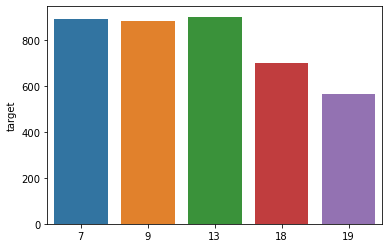

In [8]:
x=df_train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [9]:
df_train.isna().sum()

text      112
target      0
title       0
date        0
dtype: int64

In [10]:
# WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==7]['word_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==9]['word_count'].mean()) #Non-Disaster tweets

112.54780652418448
118.81426953567384


In [11]:
df_train = df_train.dropna()
df_test = df_test.dropna()

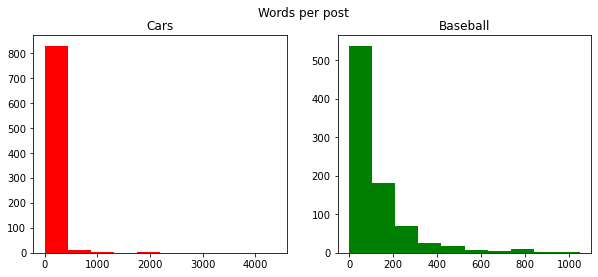

In [12]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==7]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Cars')
train_words=df_train[df_train['target']==9]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Baseball')
fig.suptitle('Words per post')
plt.show()

In [13]:
# CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==7]['char_count'].mean()) # Cars
print(df_train[df_train['target']==9]['char_count'].mean()) # Baseball

683.3851590106007
704.0571761960326


In [14]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [15]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x))

In [20]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],df_train["title"],test_size=0.2,shuffle=True, stratify=df_train["title"], random_state=2)
X_test = df_test['clean_text']
y_test = df_test['title']
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_val_tok= [nltk.word_tokenize(i) for i in X_val]
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [21]:
#Tf-Idf vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

NO SE USA


train_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(df_train.clean_text)]

#df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']]
#model = Doc2Vec(df_train['clean_text_tok'],min_count=1) 
#model.train(df_train['clean_text_tok'],total_examples=model.corpus_count,epochs=model.epochs) 
#vocabulary = model.wv.key_to_index
#print(vocabulary)
#X_train_vectors_w2v = model.infer_vector(X_train)


#build the model
model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs = 40)
#build vocab
model.build_vocab(train_docs)
#train model
model.train(train_docs, total_examples=model.corpus_count, epochs=model.epochs)

#w2v = dict(zip(model.wv.index_to_key, model.wv.syn0)) 
#modelw = MeanEmbeddingVectorizer(w2v)
# converting text to numerical data using Word2Vec
#X_train_vectors_w2v = modelw.transform(X_train_tok)
#X_val_vectors_w2v = modelw.transform(X_test_tok)

NO SE USA

# Obtain vectors via doc2vec

#obtain vectors
X_test_w2v = [model.infer_vector((X_test))]
X_test_w2v
X_train_w2v = [model.infer_vector((df_train['clean_text'][i].split(' '))) 
            for i in range(0,len(df_train['clean_text']))]





In [22]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, balanced_accuracy_score

lr_acc = accuracy_score(y_test, y_predict)
lr_f1 = f1_score(y_test, y_predict, average ='weighted')
lr_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Logistic Regression(tf-idf) is {lr_acc} \n")
print(f"Test Balanced Accuracy of Logistic Regression(tf-idf) is {lr_bacc} \n")
print(f"Test F1-score weighted of Logistic Regression(tf-idf) is {lr_f1} \n")

                    precision    recall  f1-score   support

         rec.autos       0.96      0.93      0.94        98
rec.sport.baseball       0.93      0.96      0.95       109
           sci.med       0.92      0.89      0.90        88
talk.politics.misc       0.76      0.89      0.82        73
talk.religion.misc       0.92      0.76      0.83        59

          accuracy                           0.90       427
         macro avg       0.90      0.89      0.89       427
      weighted avg       0.90      0.90      0.90       427

Confusion Matrix:
 [[ 91   1   1   4   1]
 [  0 105   2   2   0]
 [  0   3  78   5   2]
 [  3   2   2  65   1]
 [  1   2   2   9  45]]
Test Accuracy of Logistic Regression(tf-idf) is 0.8992974238875878 

Test Balanced Accuracy of Logistic Regression(tf-idf) is 0.8862721281079065 

Test F1-score weighted of Logistic Regression(tf-idf) is 0.899543734993221 



In [23]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))

nb_acc = accuracy_score(y_test, y_predict)
nb_f1 = f1_score(y_test, y_predict, average ='weighted')
nb_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Naive Bayes(tf-idf) is {nb_acc} \n")
print(f"Test Balanced Accuracy of Naive Bayes(tf-idf) is {nb_bacc} \n")
print(f"Test F1-score weighted of Naive Bayes(tf-idf) is {nb_f1} \n")

                    precision    recall  f1-score   support

         rec.autos       0.97      0.91      0.94        98
rec.sport.baseball       0.95      0.95      0.95       109
           sci.med       0.76      0.93      0.84        88
talk.politics.misc       0.70      0.88      0.78        73
talk.religion.misc       0.96      0.41      0.57        59

          accuracy                           0.85       427
         macro avg       0.87      0.82      0.81       427
      weighted avg       0.87      0.85      0.84       427

Confusion Matrix:
 [[ 89   3   3   3   0]
 [  0 104   3   2   0]
 [  1   1  82   3   1]
 [  2   1   6  64   0]
 [  0   1  14  20  24]]
Test Accuracy of Naive Bayes(tf-idf) is 0.8501170960187353 

Test Balanced Accuracy of Naive Bayes(tf-idf) is 0.8155203754550697 

Test F1-score weighted of Naive Bayes(tf-idf) is 0.8414821598989551 



In [24]:
svc_tfidf = SVC()
svc_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = svc_tfidf.predict(X_test_vectors_tfidf)
#y_prob = svc_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))

svm_acc = accuracy_score(y_test, y_predict)
svm_f1 = f1_score(y_test, y_predict, average ='weighted')
svm_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Support Vector Machine (tf-idf) is {svm_acc} \n")
print(f"Test Balanced Accuracy of Support Vector Machine (tf-idf) is {svm_bacc} \n")
print(f"Test F1-score weighted of Support Vector Machine (tf-idf) is {svm_f1} \n")

                    precision    recall  f1-score   support

         rec.autos       0.98      0.91      0.94        98
rec.sport.baseball       0.89      0.95      0.92       109
           sci.med       0.84      0.90      0.87        88
talk.politics.misc       0.73      0.89      0.80        73
talk.religion.misc       0.97      0.59      0.74        59

          accuracy                           0.87       427
         macro avg       0.88      0.85      0.85       427
      weighted avg       0.88      0.87      0.87       427

Confusion Matrix:
 [[ 89   4   2   3   0]
 [  0 104   3   2   0]
 [  0   4  79   4   1]
 [  2   3   3  65   0]
 [  0   2   7  15  35]]
Test Accuracy of Support Vector Machine (tf-idf) is 0.8711943793911007 

Test Balanced Accuracy of Support Vector Machine (tf-idf) is 0.8487300552575056 

Test F1-score weighted of Support Vector Machine (tf-idf) is 0.8690033158941539 



In [25]:
dt_tfidf = DecisionTreeClassifier()
dt_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = dt_tfidf.predict(X_test_vectors_tfidf)
#y_prob = dt_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))

dt_acc = accuracy_score(y_test, y_predict)
dt_f1 = f1_score(y_test, y_predict, average ='weighted')
dt_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Decision Tree(tf-idf) is {dt_acc} \n")
print(f"Test Balanced Accuracy of Decision Tree(tf-idf) is {dt_bacc} \n")
print(f"Test F1-score weighted of Decision Tree(tf-idf) is {dt_f1} \n")

                    precision    recall  f1-score   support

         rec.autos       0.78      0.69      0.74        98
rec.sport.baseball       0.73      0.83      0.78       109
           sci.med       0.68      0.72      0.70        88
talk.politics.misc       0.66      0.66      0.66        73
talk.religion.misc       0.67      0.59      0.63        59

          accuracy                           0.71       427
         macro avg       0.71      0.70      0.70       427
      weighted avg       0.71      0.71      0.71       427

Confusion Matrix:
 [[68 10  6  8  6]
 [ 5 90  6  4  4]
 [ 5  9 63  8  3]
 [ 7  6  8 48  4]
 [ 2  8  9  5 35]]
Test Accuracy of Decision Tree(tf-idf) is 0.711943793911007 

Test Balanced Accuracy of Decision Tree(tf-idf) is 0.6972458601764776 

Test F1-score weighted of Decision Tree(tf-idf) is 0.7105841123365149 



In [26]:
nn_tfidf = MLPClassifier()
nn_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nn_tfidf.predict(X_test_vectors_tfidf)
#y_prob = dt_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))

nn_acc = accuracy_score(y_test, y_predict)
nn_f1 = f1_score(y_test, y_predict, average ='weighted')
nn_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Neural Network(tf-idf) is {nn_acc} \n")
print(f"Test Balanced Accuracy of Neural Network(tf-idf) is {nn_bacc} \n")
print(f"Test F1-score weighted of Neural Network(tf-idf) is {nn_f1} \n")

                    precision    recall  f1-score   support

         rec.autos       0.96      0.92      0.94        98
rec.sport.baseball       0.91      0.97      0.94       109
           sci.med       0.95      0.90      0.92        88
talk.politics.misc       0.79      0.90      0.84        73
talk.religion.misc       0.92      0.76      0.83        59

          accuracy                           0.90       427
         macro avg       0.90      0.89      0.89       427
      weighted avg       0.91      0.90      0.90       427

Confusion Matrix:
 [[ 90   2   2   3   1]
 [  1 106   1   1   0]
 [  1   3  79   4   1]
 [  2   3   0  66   2]
 [  0   3   1  10  45]]
Test Accuracy of Decision Tree(tf-idf) is 0.9039812646370023 

Test Balanced Accuracy of Decision Tree(tf-idf) is 0.8910786274668215 

Test F1-score weighted of Decision Tree(tf-idf) is 0.9039231662203698 



In [27]:
X_train_vectors_tfidf = X_train_vectors_tfidf.toarray()
X_val_vectors_tfidf = X_val_vectors_tfidf.toarray()
X_test_vectors_tfidf = X_test_vectors_tfidf.toarray()

In [29]:
from keras import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [30]:
# one hot encode
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = tf.keras.utils.to_categorical(encoder.transform(y_train))
y_val = tf.keras.utils.to_categorical(encoder.transform(y_val))
y_test = tf.keras.utils.to_categorical(encoder.transform(y_test))
y_train

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [31]:
model = Sequential()
model.add(Dense(16, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_vectors_tfidf, y_train,
                    epochs=10, validation_data=(X_val_vectors_tfidf, y_val))

Epoch 1/10
96/96 [==============================] - 1s 6ms/step - loss: 1.5341 - accuracy: 0.5580 - val_loss: 1.4322 - val_accuracy: 0.7272
Epoch 2/10
96/96 [==============================] - 0s 4ms/step - loss: 1.2795 - accuracy: 0.7690 - val_loss: 1.1792 - val_accuracy: 0.7963
Epoch 3/10
96/96 [==============================] - 0s 4ms/step - loss: 0.9875 - accuracy: 0.8595 - val_loss: 0.9433 - val_accuracy: 0.8407
Epoch 4/10
96/96 [==============================] - 0s 4ms/step - loss: 0.7496 - accuracy: 0.9131 - val_loss: 0.7687 - val_accuracy: 0.8616
Epoch 5/10
96/96 [==============================] - 0s 4ms/step - loss: 0.5732 - accuracy: 0.9412 - val_loss: 0.6506 - val_accuracy: 0.8695
Epoch 6/10
96/96 [==============================] - 0s 4ms/step - loss: 0.4541 - accuracy: 0.9559 - val_loss: 0.5717 - val_accuracy: 0.8734
Epoch 7/10
96/96 [==============================] - 0s 4ms/step - loss: 0.3700 - accuracy: 0.9641 - val_loss: 0.5167 - val_accuracy: 0.8721
Epoch 8/10
96/96 [==

In [32]:
#Predict y value for test dataset
y_predict = model.predict(X_test_vectors_tfidf)
print(classification_report(y_test.argmax(axis=1), y_predict.argmax(axis=1)))
print('Confusion Matrix:\n',confusion_matrix(y_test.argmax(axis=1), y_predict.argmax(axis=1)))

acc = accuracy_score(y_test.argmax(axis=1), y_predict.argmax(axis=1))
f1 = f1_score(y_test.argmax(axis=1), y_predict.argmax(axis=1), average ='weighted')
#bacc = balanced_accuracy_score(y_test.argmax(axis=1), y_predict.argmax(axis=1))

print(f"Test Accuracy of Neural Network(tf-idf) is {acc} \n")
#print(f"Test Balanced Accuracy of Naive Bayes(tf-idf) is {bacc} \n")
print(f"Test F1-score weighted of Neural Network(tf-idf) is {f1} \n")

              precision    recall  f1-score   support

           0       0.91      0.92      0.91        98
           1       0.96      0.96      0.96       109
           2       0.94      0.89      0.91        88
           3       0.79      0.93      0.86        73
           4       0.92      0.78      0.84        59

    accuracy                           0.91       427
   macro avg       0.90      0.90      0.90       427
weighted avg       0.91      0.91      0.91       427

Confusion Matrix:
 [[ 90   3   1   3   1]
 [  2 105   0   2   0]
 [  2   1  78   5   2]
 [  3   0   1  68   1]
 [  2   0   3   8  46]]
Test Accuracy of Neural Network(tf-idf) is 0.9063231850117096 

Test F1-score weighted of Neural Network(tf-idf) is 0.9064690062586639 

